# OpenVINO Training Extension - Object Detection
In this tutorial, we will go through 
  * Train a ATSS-MobileNetV2 detection model with a demo dataset
  * Perform inference on the trained model
  * Convert PyTorch model to OpenVINO IR and perform benchmark with [OpenVINO Benchmark App](https://docs.openvino.ai/latest/openvino_inference_engine_tools_benchmark_tool_README.html#benchmark-python-tool)
  * Quantize and Compress PyTorch model with [NNCF](https://github.com/openvinotoolkit/nncf)
  * Compare accuracy and FPS performance results

## Install OTE Object Detection
Please run the bash script: `external/mmdetection/init_venv.sh`. Check our [quick start guide](https://github.com/openvinotoolkit/training_extensions/blob/develop/QUICK_START_GUIDE.md#setup-openvino-training-extensions) for more detail.

### Prerequisites
- Ubuntu 18.04 / 20.04
- Python 3.8+
- for training on GPU: [CUDA Toolkit 11.1](https://developer.nvidia.com/cuda-11.1.1-download-archive)

## Import everything
Import third-party libraries along with OTE SDK and OTE CLI in this part.  
OTE SDK provides interfaces for training models, running inference, converting models to OpenVINO, optimising models with NNCF, etc.  
[OTE CLI](https://github.com/openvinotoolkit/training_extensions/tree/develop/ote_cli) provides a set of commands to train/convert/evaluate/optimise model templates.
In this example, we show how to use APIs in OTE CLI to list templates and their task.

In [1]:
import cpuinfo
import os
import re

import cv2
import numpy as np
import tabulate
import torch

from ote_sdk.configuration.helper import create as create_parameters_from_parameters_schema
from ote_sdk.entities.inference_parameters import InferenceParameters
from ote_sdk.entities.label_schema import LabelSchemaEntity
from ote_sdk.entities.model import ModelEntity
from ote_sdk.entities.resultset import ResultSetEntity
from ote_sdk.entities.subset import Subset
from ote_sdk.entities.task_environment import TaskEnvironment
from ote_sdk.entities.optimization_parameters import OptimizationParameters
from ote_sdk.usecases.tasks.interfaces.export_interface import ExportType
from ote_sdk.usecases.tasks.interfaces.optimization_interface import OptimizationType

from ote_cli.datasets import get_dataset_class
from ote_cli.registry import Registry
from ote_cli.utils.importing import get_impl_class
from ote_cli.utils.io import save_model_data

/home/yuchunli/git/training_extensions/external/model-preparation-algorithm/venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Model Templates
In OTE, we provide a small pool of computer vision models that are optimized and can get a decent result without too much tuning.
For object detection, 3 model templates that are available: ATSS-MobileNetV2, SSD-MobileNetV2, and YOLOX-CSPDarkNet. 
Among these three models, ATSS-MobileNetV2 is the most accurate, YOLOX-CSPDarkNet is the least accurate but fastest, and SSD-MobileNetV2 sits in the middle. The detail of each model can be found [here](https://github.com/openvinotoolkit/training_extensions/tree/develop/external)

In [2]:
templates_dir = '../external'
registry = Registry(templates_dir)
print(registry)

- id: Custom_Rotated_Detection_via_Instance_Segmentation_MaskRCNN_ResNet50
  name: MaskRCNN-ResNet50
  path: /home/yuchunli/git/training_extensions/external/model-preparation-algorithm/configs/rotated-detection/resnet50_maskrcnn/template.yaml
  task_type: ROTATED_DETECTION
- id: Custom_Rotated_Detection_via_Instance_Segmentation_MaskRCNN_EfficientNetB2B
  name: MaskRCNN-EfficientNetB2B
  path: /home/yuchunli/git/training_extensions/external/model-preparation-algorithm/configs/rotated-detection/efficientnetb2b_maskrcnn/template.yaml
  task_type: ROTATED_DETECTION
- id: Custom_Counting_Instance_Segmentation_MaskRCNN_ResNet50
  name: MaskRCNN-ResNet50
  path: /home/yuchunli/git/training_extensions/external/model-preparation-algorithm/configs/instance-segmentation/resnet50_maskrcnn/template.yaml
  task_type: INSTANCE_SEGMENTATION
- id: Custom_Counting_Instance_Segmentation_MaskRCNN_EfficientNetB2B
  name: MaskRCNN-EfficientNetB2B
  path: /home/yuchunli/git/training_extensions/external/mode

## Adaptive Training Sample Selection (ATSS)
This tutorial we demonstrate training a object detection with ATSS head and MobileNetV2 backbone. Please refer to ATSS introduced in [Bridging the Gap Between Anchor-based and Anchor-free Detection via Adaptive Training Sample Selection](http://arxiv.org/abs/1912.02424) and [MobileNetV2](http://arxiv.org/abs/1801.04381) for more detail.

<!--bibtex
@article{DBLP:journals/corr/abs-1912-02424,
  author    = {Shifeng Zhang and
               Cheng Chi and
               Yongqiang Yao and
               Zhen Lei and
               Stan Z. Li},
  title     = {Bridging the Gap Between Anchor-based and Anchor-free Detection via
               Adaptive Training Sample Selection},
  journal   = {CoRR},
  volume    = {abs/1912.02424},
  year      = {2019},
  url       = {http://arxiv.org/abs/1912.02424},
  eprinttype = {arXiv},
  eprint    = {1912.02424},
  timestamp = {Tue, 12 Apr 2022 15:00:34 +0200},
  biburl    = {https://dblp.org/rec/journals/corr/abs-1912-02424.bib},
  bibsource = {dblp computer science bibliography, https://dblp.org}
}

@article{DBLP:journals/corr/abs-1801-04381,
  author    = {Mark Sandler and
               Andrew G. Howard and
               Menglong Zhu and
               Andrey Zhmoginov and
               Liang{-}Chieh Chen},
  title     = {Inverted Residuals and Linear Bottlenecks: Mobile Networks for Classification,
               Detection and Segmentation},
  journal   = {CoRR},
  volume    = {abs/1801.04381},
  year      = {2018},
  url       = {http://arxiv.org/abs/1801.04381},
  eprinttype = {arXiv},
  eprint    = {1801.04381},
  timestamp = {Tue, 12 Jan 2021 15:30:06 +0100},
  biburl    = {https://dblp.org/rec/journals/corr/abs-1801-04381.bib},
  bibsource = {dblp computer science bibliography, https://dblp.org}
}
-->

### Load ATSS-MobileNetV2 template and its hyper parameters
Load the ATSS model template via registry: `registry.get('Custom_Object_Detection_Gen3_ATSS')`.  
Similarly, getting SSD-MobileNetv2 template is the same but calling with `registry.get('Custom_Object_Detection_Gen3_SSD')`.

In [3]:
model_template = registry.get('Custom_Object_Detection_Gen3_ATSS')
hyper_parameters = model_template.hyper_parameters.data
hyper_parameters = create_parameters_from_parameters_schema(hyper_parameters)

for p in hyper_parameters.learning_parameters.parameters:
    print(f'{p}: {getattr(hyper_parameters.learning_parameters, p)}')

batch_size: 8
early_stop_iteration_patience: 0
early_stop_patience: 10
early_stop_start: 3
enable_early_stopping: True
learning_rate: 0.004
learning_rate_warmup_iters: 3
num_checkpoints: 5
num_iters: 200
num_workers: 2
use_adaptive_interval: True


### Check GPU device and Tweak parameters
For our demo, training with a low epoch number (15 epoch in this case) should be sufficient to get a decent model.  For other more difficult datasets (e.g. COCO or VOC), we recommend stick with the default epoch number as it requires more training for models to start converging.  

> We also change the batch size from 8 to 2 as for some GPUs might not have enough memory to fit everything and it'd lead to out of memory (OOM). 

In [4]:
# Check CUDA driver is available
assert torch.cuda.is_available(), "CUDA driver not available"
print(torch.cuda.get_device_name(0))

# Check GPU Memory
print(f"GPU memory: {torch.cuda.get_device_properties(0).total_memory/1024 * 1E-6:.2f} GB")

NVIDIA GeForce RTX 3090
GPU memory: 24.85 GB


In [5]:
hyper_parameters.learning_parameters.batch_size = 2
hyper_parameters.learning_parameters.num_iters = 15

### Load the Demo dataset

In [6]:
Dataset = get_dataset_class(model_template.task_type)

dataset = Dataset(
    train_subset={'ann_file': '../data/airport/annotation_person_train.json', 'data_root': '../data/airport/train'},
    val_subset={'ann_file': '../data/airport/annotation_person_val.json', 'data_root': '../data/airport/val'}
)
labels_schema = LabelSchemaEntity.from_labels(dataset.get_labels())

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


## OTE Detection Task

In OTE SDK, we define a set of task interface for each algorithm. In this example, we demonstrate how to train an OTE object detection template via `DetectionTrainTask` API.  
This API presents a list methods to train/infer/convert: 
  * `DetectionTrainTask.train`: train a model on the given `dataset`
  * `DetectionTrainTask.infer`: run inference on the given `dataset`
  * `DetectionTrainTask.export`: convert the trained PyTorch model to OpenVINO 

> 5 computer vision tasks are supported in OTE - _anomaly detection, classification, detection, instance segmentation and semantic segmentation_, and each task is fully independent from another. You don't need to create a task interface, as OTE CLI provides `get_impl_class` function to get the corresponded task interface from the model template. For more information about model template, please refer [here](https://github.com/openvinotoolkit/training_extensions/tree/develop/external).

In [7]:
Task = get_impl_class(model_template.entrypoints.base)

environment = TaskEnvironment(
    model=None,
    hyper_parameters=hyper_parameters,
    label_schema=labels_schema,
    model_template=model_template)
        
task = Task(task_environment=environment)

2022-11-09 12:48:15,067 | INFO : created output path at /tmp/MPA-task-4h8zv1d2


### Train ATSS-MobileNetV2 PyTorch model
Train a PyTorch model via Detection task API. Progress is logged, and evaluation results can also be observed while training.
> It might take a while depends on your hardware devices. 

In [8]:
torch_model = ModelEntity(
    dataset,
    environment.get_model_configuration(),
)

task.train(dataset, torch_model)
save_model_data(torch_model, "./torch_model")

2022-11-09 12:48:15,124 | INFO : train()
2022-11-09 12:48:15,126 | INFO : init data cfg.
2022-11-09 12:48:15,127 | INFO : initializing....
2022-11-09 12:48:15,128 | INFO : called _init_recipe()
2022-11-09 12:48:15,129 | INFO : train type = Incremental
2022-11-09 12:48:15,157 | WARNING : Duplicate key is detected among bases [{'data_root_path', 'data'}]
2022-11-09 12:48:15,160 | INFO : initialized recipe = /home/yuchunli/git/training_extensions/external/model-preparation-algorithm/submodule/recipes/stages/detection/imbalance.py
2022-11-09 12:48:15,167 | WARNING : Duplicate key is detected among bases [{'model'}]
2022-11-09 12:48:15,169 | INFO : initialized.
2022-11-09 12:48:15,170 | INFO : running task... kwargs = {}
2022-11-09 12:48:15,171 | INFO : called build_recipe()
2022-11-09 12:48:15,172 | INFO : seems to be passed stage yaml...
2022-11-09 12:48:15,173 | INFO : build_stage()
2022-11-09 12:48:15,176 | INFO : Training seed was set to 5 w/ deterministic=False.
2022-11-09 12:48:15,17

2022-11-09 12:48:15,900 - mmdet - WARNING - Init model mobilenetv2_w1, pretrained=True, models cache ~/.torch/models


[ WARNING ] Init model mobilenetv2_w1, pretrained=True, models cache ~/.torch/models


[ WARNING ]  Init model mobilenetv2_w1, pretrained=True, models cache ~/.torch/models


Use load_from_http loader
2022-11-09 12:48:18,587 | INFO : ----------------- CustomATSS.load_state_dict_pre_hook() called w/ prefix: 
2022-11-09 12:48:18,588 | INFO : [] -> ['person'] ([-1])
2022-11-09 12:48:18,813 | INFO : Task Adaptation: [] => ['person']
2022-11-09 12:48:18,814 | INFO : - Efficient Mode: False
2022-11-09 12:48:18,815 | INFO : - Sampler type: cls_incr
2022-11-09 12:48:18,816 | INFO : - Sampler flag: False


2022-11-09 12:48:18,817 - mmdet - INFO - Start running, host: yuchunli@yuchunli-desk, work_dir: /tmp/MPA-task-4h8zv1d2/stage00_DetectionTrainer-train


[ INFO ] Start running, host: yuchunli@yuchunli-desk, work_dir: /tmp/MPA-task-4h8zv1d2/stage00_DetectionTrainer-train


[ INFO ]  Start running, host: %s, work_dir: %s
2022-11-09 12:48:18,819 - mmdet - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) ReduceLROnPlateauLrUpdaterHook     
(ABOVE_NORMAL) Fp16OptimizerHook                  
(ABOVE_NORMAL) EMAHook                            
(NORMAL      ) CheckpointHook                     
(NORMAL      ) EvalHook                           
(NORMAL      ) CancelInterfaceHook                
(NORMAL      ) LoggerReplaceHook                  
(71          ) OTEProgressHook                    
(75          ) LazyEarlyStoppingHook              
(VERY_LOW    ) TextLoggerHook                     
(VERY_LOW    ) TensorboardLoggerHook              
(VERY_LOW    ) OTELoggerHook                      
 -------------------- 
before_train_epoch:
(VERY_HIGH   ) ReduceLROnPlateauLrUpdaterHook     
(ABOVE_NORMAL) EMAHook                            
(NORMAL      ) EvalHook                           
(NORMAL      ) TaskAdaptHook                

[ INFO ] Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) ReduceLROnPlateauLrUpdaterHook     
(ABOVE_NORMAL) Fp16OptimizerHook                  
(ABOVE_NORMAL) EMAHook                            
(NORMAL      ) CheckpointHook                     
(NORMAL      ) EvalHook                           
(NORMAL      ) CancelInterfaceHook                
(NORMAL      ) LoggerReplaceHook                  
(71          ) OTEProgressHook                    
(75          ) LazyEarlyStoppingHook              
(VERY_LOW    ) TextLoggerHook                     
(VERY_LOW    ) TensorboardLoggerHook              
(VERY_LOW    ) OTELoggerHook                      
 -------------------- 
before_train_epoch:
(VERY_HIGH   ) ReduceLROnPlateauLrUpdaterHook     
(ABOVE_NORMAL) EMAHook                            
(NORMAL      ) EvalHook                           
(NORMAL      ) TaskAdaptHook                      
(LOW         ) IterTimerHook                      
(71          ) OTEProg

[ INFO ]  Hooks will be executed in the following order:
%s
2022-11-09 12:48:18,821 - mmdet - INFO - workflow: [('train', 1)], max: 15 epochs


[ INFO ] workflow: [('train', 1)], max: 15 epochs


[ INFO ]  workflow: %s, max: %d epochs


2022-11-09 12:48:18,832 | INFO : cancel hook is initialized
2022-11-09 12:48:18,833 | INFO : logger in the runner is replaced to the MPA logger


2022-11-09 12:48:22,207 - mmcls - WARNING - training progress 1%


[ WARNING ] training progress 1%


[ WARNING ]  training progress 1%


2022-11-09 12:48:22,211 | INFO : Epoch [1][1/5]	lr: 1.333e-03, eta: 6:50:40, time: 3.330, data_time: 0.230, memory: 1112, current_iters: 0, loss_cls: 1.1881, loss_bbox: 0.3118, loss_centerness: 0.5929, loss: 2.0928, grad_norm: 6.1971
2022-11-09 12:48:22,978 | INFO : Exp name: /tmp/MPA-task-4h8zv1d2/stage00_DetectionTrainer-train
2022-11-09 12:48:22,980 | INFO : Epoch [1][5/5]	lr: 4.000e-03, eta: 1:36:49, time: 0.820, data_time: 0.052, memory: 1200, current_iters: 4, loss_cls: 1.0776, loss_bbox: 0.2731, loss_centerness: 0.5902, loss: 1.9408, grad_norm: 6.4527
2022-11-09 12:48:23,063 | INFO : Saving checkpoint at 1 epochs
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 10/10, 21.3 task/s, elapsed: 0s, ETA:     0s
---------------iou_thr: 0.5---------------
2022-11-09 12:48:23,904 | INFO : 
+--------+-----+------+--------+-------+
| class  | gts | dets | recall | ap    |
+--------+-----+------+--------+-------+
| person | 42  | 0    | 0.000  | 0.000 |
+--------+-----+------+--------+-------+
| mAP    |

2022-11-09 12:48:24,975 - mmcls - WARNING - training progress 11%


[ WARNING ] training progress 11%


[ WARNING ]  training progress 11%


2022-11-09 12:48:25,345 | INFO : Exp name: /tmp/MPA-task-4h8zv1d2/stage00_DetectionTrainer-train
2022-11-09 12:48:25,346 | INFO : Epoch [2][5/5]	lr: 4.000e-03, eta: 0:53:01, time: 0.251, data_time: 0.056, memory: 1200, current_iters: 9, loss_cls: 0.4198, loss_bbox: 0.2303, loss_centerness: 0.5841, loss: 1.2342, grad_norm: 11.0976
2022-11-09 12:48:25,463 | INFO : Saving checkpoint at 2 epochs
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 10/10, 20.5 task/s, elapsed: 0s, ETA:     0s
---------------iou_thr: 0.5---------------
2022-11-09 12:48:26,341 | INFO : 
+--------+-----+------+--------+-------+
| class  | gts | dets | recall | ap    |
+--------+-----+------+--------+-------+
| person | 42  | 2    | 0.048  | 0.048 |
+--------+-----+------+--------+-------+
| mAP    |     |      |        | 0.048 |
+--------+-----+------+--------+-------+
2022-11-09 12:48:26,485 | INFO : Now best checkpoint is saved as best_mAP_epoch_2.pth.
2022-11-09 12:48:26,486 | INFO : Best mAP is 0.0476 at 2 epoch.
2022-11-09

2022-11-09 12:48:27,771 - mmcls - WARNING - training progress 20%


[ WARNING ] training progress 20%


[ WARNING ]  training progress 20%


2022-11-09 12:48:27,775 | INFO : Exp name: /tmp/MPA-task-4h8zv1d2/stage00_DetectionTrainer-train
2022-11-09 12:48:27,776 | INFO : Epoch [3][5/5]	lr: 4.000e-03, eta: 0:37:42, time: 0.254, data_time: 0.057, memory: 1200, current_iters: 14, loss_cls: 0.1916, loss_bbox: 0.2292, loss_centerness: 0.5853, loss: 1.0061, grad_norm: 6.7234
2022-11-09 12:48:27,885 | INFO : Saving checkpoint at 3 epochs
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 10/10, 20.8 task/s, elapsed: 0s, ETA:     0s
---------------iou_thr: 0.5---------------
2022-11-09 12:48:28,778 | INFO : 
+--------+-----+------+--------+-------+
| class  | gts | dets | recall | ap    |
+--------+-----+------+--------+-------+
| person | 42  | 43   | 0.976  | 0.976 |
+--------+-----+------+--------+-------+
| mAP    |     |      |        | 0.976 |
+--------+-----+------+--------+-------+
2022-11-09 12:48:28,938 | INFO : Now best checkpoint is saved as best_mAP_epoch_3.pth.
2022-11-09 12:48:28,939 | INFO : Best mAP is 0.9762 at 3 epoch.
2022-11-09

2022-11-09 12:48:32,168 - mmcls - WARNING - training progress 31%


[ WARNING ] training progress 31%


[ WARNING ]  training progress 31%


2022-11-09 12:48:32,537 | INFO : Exp name: /tmp/MPA-task-4h8zv1d2/stage00_DetectionTrainer-train
2022-11-09 12:48:32,538 | INFO : Epoch [5][5/5]	lr: 4.000e-03, eta: 0:23:38, time: 0.264, data_time: 0.063, memory: 1200, current_iters: 24, loss_cls: 0.1418, loss_bbox: 0.2193, loss_centerness: 0.5845, loss: 0.9457, grad_norm: 6.0043
2022-11-09 12:48:32,646 | INFO : Saving checkpoint at 5 epochs
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 10/10, 20.5 task/s, elapsed: 0s, ETA:     0s
---------------iou_thr: 0.5---------------
2022-11-09 12:48:33,534 | INFO : 
+--------+-----+------+--------+-------+
| class  | gts | dets | recall | ap    |
+--------+-----+------+--------+-------+
| person | 42  | 70   | 0.976  | 0.976 |
+--------+-----+------+--------+-------+
| mAP    |     |      |        | 0.976 |
+--------+-----+------+--------+-------+
2022-11-09 12:48:33,615 | INFO : Exp name: /tmp/MPA-task-4h8zv1d2/stage00_DetectionTrainer-train
2022-11-09 12:48:33,616 | INFO : Epoch(val) [5][5]	AP50: 0.9760,

2022-11-09 12:48:34,812 - mmcls - WARNING - training progress 40%


[ WARNING ] training progress 40%


[ WARNING ]  training progress 40%


2022-11-09 12:48:34,815 | INFO : Exp name: /tmp/MPA-task-4h8zv1d2/stage00_DetectionTrainer-train
2022-11-09 12:48:34,816 | INFO : Epoch [6][5/5]	lr: 4.000e-03, eta: 0:19:27, time: 0.235, data_time: 0.054, memory: 1200, current_iters: 29, loss_cls: 0.1224, loss_bbox: 0.2671, loss_centerness: 0.5755, loss: 0.9650, grad_norm: 6.9279
2022-11-09 12:48:34,920 | INFO : Saving checkpoint at 6 epochs
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 10/10, 22.4 task/s, elapsed: 0s, ETA:     0s
---------------iou_thr: 0.5---------------
2022-11-09 12:48:35,738 | INFO : 
+--------+-----+------+--------+-------+
| class  | gts | dets | recall | ap    |
+--------+-----+------+--------+-------+
| person | 42  | 88   | 0.976  | 0.976 |
+--------+-----+------+--------+-------+
| mAP    |     |      |        | 0.976 |
+--------+-----+------+--------+-------+
2022-11-09 12:48:35,818 | INFO : Exp name: /tmp/MPA-task-4h8zv1d2/stage00_DetectionTrainer-train
2022-11-09 12:48:35,819 | INFO : Epoch(val) [6][5]	AP50: 0.9760,

2022-11-09 12:48:39,032 - mmcls - WARNING - training progress 51%


[ WARNING ] training progress 51%


[ WARNING ]  training progress 51%


2022-11-09 12:48:39,429 | INFO : Exp name: /tmp/MPA-task-4h8zv1d2/stage00_DetectionTrainer-train
2022-11-09 12:48:39,430 | INFO : Epoch [8][5/5]	lr: 4.000e-03, eta: 0:13:28, time: 0.245, data_time: 0.054, memory: 1200, current_iters: 39, loss_cls: 0.1023, loss_bbox: 0.2880, loss_centerness: 0.5886, loss: 0.9789, grad_norm: 5.5740
2022-11-09 12:48:39,528 | INFO : Saving checkpoint at 8 epochs
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 10/10, 20.7 task/s, elapsed: 0s, ETA:     0s
---------------iou_thr: 0.5---------------
2022-11-09 12:48:40,435 | INFO : 
+--------+-----+------+--------+-------+
| class  | gts | dets | recall | ap    |
+--------+-----+------+--------+-------+
| person | 42  | 141  | 0.976  | 0.976 |
+--------+-----+------+--------+-------+
| mAP    |     |      |        | 0.976 |
+--------+-----+------+--------+-------+
2022-11-09 12:48:40,528 | INFO : Exp name: /tmp/MPA-task-4h8zv1d2/stage00_DetectionTrainer-train
2022-11-09 12:48:40,529 | INFO : Epoch(val) [8][5]	AP50: 0.9760,

2022-11-09 12:48:41,812 - mmcls - WARNING - training progress 60%


[ WARNING ] training progress 60%


[ WARNING ]  training progress 60%


2022-11-09 12:48:41,814 | INFO : Exp name: /tmp/MPA-task-4h8zv1d2/stage00_DetectionTrainer-train
2022-11-09 12:48:41,815 | INFO : Epoch [9][5/5]	lr: 4.000e-04, eta: 0:11:01, time: 0.254, data_time: 0.056, memory: 1200, current_iters: 44, loss_cls: 0.0864, loss_bbox: 0.2858, loss_centerness: 0.5848, loss: 0.9570, grad_norm: 5.1317
2022-11-09 12:48:41,924 | INFO : Saving checkpoint at 9 epochs
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 10/10, 21.6 task/s, elapsed: 0s, ETA:     0s
---------------iou_thr: 0.5---------------
2022-11-09 12:48:42,789 | INFO : 
+--------+-----+------+--------+-------+
| class  | gts | dets | recall | ap    |
+--------+-----+------+--------+-------+
| person | 42  | 145  | 0.976  | 0.976 |
+--------+-----+------+--------+-------+
| mAP    |     |      |        | 0.976 |
+--------+-----+------+--------+-------+
2022-11-09 12:48:42,882 | INFO : Exp name: /tmp/MPA-task-4h8zv1d2/stage00_DetectionTrainer-train
2022-11-09 12:48:42,883 | INFO : Epoch(val) [9][5]	AP50: 0.9760,

2022-11-09 12:48:45,993 - mmcls - WARNING - training progress 71%


[ WARNING ] training progress 71%


[ WARNING ]  training progress 71%


2022-11-09 12:48:46,371 | INFO : Exp name: /tmp/MPA-task-4h8zv1d2/stage00_DetectionTrainer-train
2022-11-09 12:48:46,372 | INFO : Epoch [11][5/5]	lr: 4.000e-04, eta: 0:06:53, time: 0.243, data_time: 0.058, memory: 1200, current_iters: 54, loss_cls: 0.0714, loss_bbox: 0.2221, loss_centerness: 0.5757, loss: 0.8692, grad_norm: 4.7079
2022-11-09 12:48:46,467 | INFO : Saving checkpoint at 11 epochs
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 10/10, 23.8 task/s, elapsed: 0s, ETA:     0s
---------------iou_thr: 0.5---------------
2022-11-09 12:48:47,322 | INFO : 
+--------+-----+------+--------+-------+
| class  | gts | dets | recall | ap    |
+--------+-----+------+--------+-------+
| person | 42  | 175  | 0.976  | 0.976 |
+--------+-----+------+--------+-------+
| mAP    |     |      |        | 0.976 |
+--------+-----+------+--------+-------+
2022-11-09 12:48:47,400 | INFO : Exp name: /tmp/MPA-task-4h8zv1d2/stage00_DetectionTrainer-train
2022-11-09 12:48:47,402 | INFO : Epoch(val) [11][5]	AP50: 0.97

2022-11-09 12:48:48,730 - mmcls - WARNING - training progress 80%


[ WARNING ] training progress 80%


[ WARNING ]  training progress 80%


2022-11-09 12:48:48,733 | INFO : Exp name: /tmp/MPA-task-4h8zv1d2/stage00_DetectionTrainer-train
2022-11-09 12:48:48,734 | INFO : Epoch [12][5/5]	lr: 4.000e-04, eta: 0:05:01, time: 0.263, data_time: 0.055, memory: 1200, current_iters: 59, loss_cls: 0.0672, loss_bbox: 0.1850, loss_centerness: 0.5818, loss: 0.8340, grad_norm: 3.8823
2022-11-09 12:48:48,843 | INFO : Saving checkpoint at 12 epochs
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 10/10, 24.9 task/s, elapsed: 0s, ETA:     0s
---------------iou_thr: 0.5---------------
2022-11-09 12:48:49,642 | INFO : 
+--------+-----+------+--------+-------+
| class  | gts | dets | recall | ap    |
+--------+-----+------+--------+-------+
| person | 42  | 187  | 0.976  | 0.976 |
+--------+-----+------+--------+-------+
| mAP    |     |      |        | 0.976 |
+--------+-----+------+--------+-------+
2022-11-09 12:48:49,730 | INFO : Exp name: /tmp/MPA-task-4h8zv1d2/stage00_DetectionTrainer-train
2022-11-09 12:48:49,731 | INFO : Epoch(val) [12][5]	AP50: 0.97

2022-11-09 12:48:53,304 - mmdet - WARNING - Init model mobilenetv2_w1, pretrained=True, models cache ~/.torch/models


[ WARNING ] Init model mobilenetv2_w1, pretrained=True, models cache ~/.torch/models


[ WARNING ]  Init model mobilenetv2_w1, pretrained=True, models cache ~/.torch/models


Use load_from_local loader
2022-11-09 12:48:53,414 | INFO : ----------------- CustomATSS.load_state_dict_pre_hook() called w/ prefix: 
2022-11-09 12:48:53,415 | INFO : ['person'] -> ['person'] ([0])
The model and loaded state dict do not match exactly

unexpected key in source state_dict: ema_backbone_features_init_block_conv_weight, ema_backbone_features_init_block_bn_weight, ema_backbone_features_init_block_bn_bias, ema_backbone_features_stage1_unit1_conv1_conv_weight, ema_backbone_features_stage1_unit1_conv1_bn_weight, ema_backbone_features_stage1_unit1_conv1_bn_bias, ema_backbone_features_stage1_unit1_conv2_conv_weight, ema_backbone_features_stage1_unit1_conv2_bn_weight, ema_backbone_features_stage1_unit1_conv2_bn_bias, ema_backbone_features_stage1_unit1_conv3_conv_weight, ema_backbone_features_stage1_unit1_conv3_bn_weight, ema_backbone_features_stage1_unit1_conv3_bn_bias, ema_backbone_features_stage2_unit1_conv1_conv_weight, ema_backbone_features_stage2_unit1_conv1_bn_weight, ema_

### Run Inference and Evaluate Result
Run inference on the validation dataset with the trained PyTorch model, and evaluate the result via `evaluate` in `Task`.

In [9]:
validation_dataset = dataset.get_subset(Subset.VALIDATION)
predicted_validation_dataset = task.infer(
    validation_dataset.with_empty_annotations(),
    InferenceParameters(is_evaluation=True))

torch_resultset = ResultSetEntity(
    model=torch_model,
    ground_truth_dataset=validation_dataset,
    prediction_dataset=predicted_validation_dataset,
)
task.evaluate(torch_resultset)
print(torch_resultset.performance)

2022-11-09 12:48:54,544 | INFO : infer()
2022-11-09 12:48:54,546 | INFO : Confidence threshold 0.07500000000000001
2022-11-09 12:48:54,548 | INFO : initializing....
2022-11-09 12:48:54,549 | INFO : called _init_recipe()
2022-11-09 12:48:54,549 | INFO : train type = Incremental
2022-11-09 12:48:54,579 | WARNING : Duplicate key is detected among bases [{'data_root_path', 'data'}]
2022-11-09 12:48:54,582 | INFO : initialized recipe = /home/yuchunli/git/training_extensions/external/model-preparation-algorithm/submodule/recipes/stages/detection/imbalance.py
2022-11-09 12:48:54,589 | WARNING : Duplicate key is detected among bases [{'model'}]
2022-11-09 12:48:54,591 | INFO : initialized.
2022-11-09 12:48:54,592 | INFO : running task... kwargs = {'eval': True, 'dump_features': True, 'dump_saliency_map': False}
2022-11-09 12:48:54,593 | INFO : called build_recipe()
2022-11-09 12:48:54,594 | INFO : seems to be passed stage yaml...
2022-11-09 12:48:54,594 | INFO : build_stage()
2022-11-09 12:48:

2022-11-09 12:48:54,674 - mmdet - WARNING - Init model mobilenetv2_w1, pretrained=True, models cache ~/.torch/models


[ WARNING ] Init model mobilenetv2_w1, pretrained=True, models cache ~/.torch/models


[ WARNING ]  Init model mobilenetv2_w1, pretrained=True, models cache ~/.torch/models


Use load_from_local loader
2022-11-09 12:48:54,808 | INFO : ----------------- CustomATSS.load_state_dict_pre_hook() called w/ prefix: 
2022-11-09 12:48:54,810 | INFO : ['person'] -> ['person'] ([0])
The model and loaded state dict do not match exactly

unexpected key in source state_dict: ema_backbone_features_init_block_conv_weight, ema_backbone_features_init_block_bn_weight, ema_backbone_features_init_block_bn_bias, ema_backbone_features_stage1_unit1_conv1_conv_weight, ema_backbone_features_stage1_unit1_conv1_bn_weight, ema_backbone_features_stage1_unit1_conv1_bn_bias, ema_backbone_features_stage1_unit1_conv2_conv_weight, ema_backbone_features_stage1_unit1_conv2_bn_weight, ema_backbone_features_stage1_unit1_conv2_bn_bias, ema_backbone_features_stage1_unit1_conv3_conv_weight, ema_backbone_features_stage1_unit1_conv3_bn_weight, ema_backbone_features_stage1_unit1_conv3_bn_bias, ema_backbone_features_stage2_unit1_conv1_conv_weight, ema_backbone_features_stage2_unit1_conv1_bn_weight, ema_

## OpenVINO  
In OTE, we integrate OpenVINO which is an open-source toolkit for model optimization. It also helps accelerate deep learning inference across a variety of Intel® processors and accelerators.  
In this section, we will show how to convert the trained PyTorch model to OpenVINO IR, evaluate the results and benchmark the model with `benchmark_app`.

### Convert PyTorch model to OpenVINO IR
By converting PyTorch model to OpenVINO IR with [Model Optimizer](https://docs.openvino.ai/latest/openvino_docs_MO_DG_Deep_Learning_Model_Optimizer_DevGuide.html) saves two files: an `.xml` file containing the model topology and a `.bin` file containing the model weights. This model can be loaded with OpenVINO Runtime.

In [10]:
exported_model = ModelEntity(
    dataset,
    environment.get_model_configuration(),
)
task.export(ExportType.OPENVINO, exported_model)
save_model_data(exported_model, "./exported_model")

2022-11-09 12:48:55,893 | INFO : Exporting the model
2022-11-09 12:48:55,896 | INFO : initializing....
2022-11-09 12:48:55,896 | INFO : called _init_recipe()
2022-11-09 12:48:55,898 | INFO : train type = Incremental
2022-11-09 12:48:55,938 | WARNING : Duplicate key is detected among bases [{'data_root_path', 'data'}]
2022-11-09 12:48:55,942 | INFO : initialized recipe = /home/yuchunli/git/training_extensions/external/model-preparation-algorithm/submodule/recipes/stages/detection/imbalance.py
2022-11-09 12:48:55,952 | WARNING : Duplicate key is detected among bases [{'model'}]
2022-11-09 12:48:55,953 | INFO : initialized.
2022-11-09 12:48:55,954 | INFO : running task... kwargs = {'precision': 'FP32', 'export': True}
2022-11-09 12:48:55,954 | INFO : called build_recipe()
2022-11-09 12:48:55,956 | INFO : seems to be passed stage yaml...
2022-11-09 12:48:55,957 | INFO : build_stage()
2022-11-09 12:48:55,959 | INFO : Training seed was set to 5 w/ deterministic=False.
2022-11-09 12:48:55,960

2022-11-09 12:48:56,031 - mmdet - WARNING - Init model mobilenetv2_w1, pretrained=True, models cache ~/.torch/models


[ WARNING ] Init model mobilenetv2_w1, pretrained=True, models cache ~/.torch/models


[ WARNING ]  Init model mobilenetv2_w1, pretrained=True, models cache ~/.torch/models


Use load_from_local loader
2022-11-09 12:48:56,168 | INFO : ----------------- CustomATSS.load_state_dict_pre_hook() called w/ prefix: 
2022-11-09 12:48:56,169 | INFO : ['person'] -> ['person'] ([0])
The model and loaded state dict do not match exactly

unexpected key in source state_dict: ema_backbone_features_init_block_conv_weight, ema_backbone_features_init_block_bn_weight, ema_backbone_features_init_block_bn_bias, ema_backbone_features_stage1_unit1_conv1_conv_weight, ema_backbone_features_stage1_unit1_conv1_bn_weight, ema_backbone_features_stage1_unit1_conv1_bn_bias, ema_backbone_features_stage1_unit1_conv2_conv_weight, ema_backbone_features_stage1_unit1_conv2_bn_weight, ema_backbone_features_stage1_unit1_conv2_bn_bias, ema_backbone_features_stage1_unit1_conv3_conv_weight, ema_backbone_features_stage1_unit1_conv3_bn_weight, ema_backbone_features_stage1_unit1_conv3_bn_bias, ema_backbone_features_stage2_unit1_conv1_conv_weight, ema_backbone_features_stage2_unit1_conv1_bn_weight, ema_

[ WARNING ]  
Detected not satisfied dependencies:
	numpy: installed: 1.21.4, required: < 1.20

Please install required versions of components or run pip installation
pip install openvino-dev


[ SUCCESS ] Generated IR version 11 model.
[ SUCCESS ] XML file: /tmp/MPA-task-4h8zv1d2/stage00_DetectionExporter-train/export/model.xml
[ SUCCESS ] BIN file: /tmp/MPA-task-4h8zv1d2/stage00_DetectionExporter-train/export/model.bin
[ SUCCESS ] Total execution time: 1.27 seconds. 
[ SUCCESS ] Memory consumed: 155 MB. 
It's been a while, check for a new version of Intel(R) Distribution of OpenVINO(TM) toolkit here https://software.intel.com/content/www/us/en/develop/tools/openvino-toolkit/download.html?cid=other&source=prod&campid=ww_2022_bu_IOTG_OpenVINO-2022-1&content=upg_all&medium=organic or on the GitHub*
[ INFO ] The model was converted to IR v11, the latest model format that corresponds to the source DL framework input/output format. While IR v11 is backwards compatible with OpenVINO Inference Engine API v1.0, please use API v2.0 (as of 2022.1) to take advantage of the latest improvements in IR v11.
Find more information about API v2.0 and IR v11 at https://docs.openvino.ai
2022-11

### Run Inference with OpenVINO and Compare Evaluate Result
Run inference on the validation dataset with the converted OpenVINO model, and evaluate the result via `evaluate` in `Task`.

In [11]:
environment.model = exported_model
ov_task = get_impl_class(model_template.entrypoints.openvino)(environment)
predicted_validation_dataset = ov_task.infer(
    validation_dataset.with_empty_annotations(),
    InferenceParameters(is_evaluation=True))
ov_resultset = ResultSetEntity(
    model=exported_model,
    ground_truth_dataset=validation_dataset,
    prediction_dataset=predicted_validation_dataset,
)
ov_task.evaluate(ov_resultset)

print(f"Original PyTorch model F1-score: {torch_resultset.performance.score.value:.4f}")
print(f"OpenVINO model F1-score: {ov_resultset.performance.score.value:.4f}")

2022-11-09 12:49:17,292 - mmdet - INFO - Loading OpenVINO OTEDetectionTask


[ INFO ] Loading OpenVINO OTEDetectionTask


[ INFO ]  Loading OpenVINO OTEDetectionTask
2022-11-09 12:49:18,187 - mmdet - INFO - OpenVINO task initialization completed


[ INFO ] OpenVINO task initialization completed


[ INFO ]  OpenVINO task initialization completed
2022-11-09 12:49:18,190 - mmdet - INFO - Start OpenVINO inference


[ INFO ] Start OpenVINO inference


[ INFO ]  Start OpenVINO inference
2022-11-09 12:49:19,095 - mmdet - INFO - OpenVINO inference completed


[ INFO ] OpenVINO inference completed


[ INFO ]  OpenVINO inference completed
2022-11-09 12:49:19,098 - mmdet - INFO - Start OpenVINO metric evaluation


[ INFO ] Start OpenVINO metric evaluation


[ INFO ]  Start OpenVINO metric evaluation
2022-11-09 12:49:19,106 - mmdet - INFO - OpenVINO metric evaluation completed


[ INFO ] OpenVINO metric evaluation completed


[ INFO ]  OpenVINO metric evaluation completed


Original PyTorch model F1-score: 0.9880
OpenVINO model F1-score: 0.9880


### Benchmark OpenVINO model
Benchmark FPS on OpenVINO IR with [`benchmark_app`](https://docs.openvino.ai/latest/openvino_inference_engine_tools_benchmark_tool_README.html#benchmark-python-tool)

In [12]:
# get CPU info 
print(cpuinfo.get_cpu_info()['brand_raw'])

Intel(R) Core(TM) i9-10980XE CPU @ 3.00GHz


In [13]:
!benchmark_app -m ./exported_model/openvino.xml  -i ../data/airport/val > ./exported_model/benchmark.txt
lines = open('./exported_model/benchmark.txt').readlines()
openvino_fps = float(re.findall(r'\d+\.\d+', lines[-1])[0])
print(f"OpenVINO FPS: {openvino_fps}")

OpenVINO FPS: 35.9


## Neural Network Compression Framework - NNCF
[NNCF](https://github.com/openvinotoolkit/nncf) provides the usage of compression algorithms for PyTorch with minimal accuracy drop. It converts your floating-point precision model to integer precision (for example, 8-bit), while maintaining accuracy within a pre-defined range. It helps to reduce the model size, memory footprint and latency, as well as improve the computational efficiency, using integer arithmetic.

### Quantize PyTorch model with NNCF
In this example, the model is quantize with [Accuracy-aware Quantization algorithm](https://github.com/openvinotoolkit/nncf/blob/develop/docs/Usage.md#accuracy-aware-model-training). This method is used to minimized accuracy drop during quantization.

In [14]:
environment.model = torch_model
nncf_model = ModelEntity(dataset, environment.get_model_configuration())
nncf_task = get_impl_class(model_template.entrypoints.nncf)(environment)
nncf_task.optimize(
        OptimizationType.NNCF,
        dataset,
        nncf_model,
        OptimizationParameters(),
    )
save_model_data(nncf_model, "./nncf_torch_model")

2022-11-09 12:50:22,491 | INFO : Base model for NNCF: /home/yuchunli/git/training_extensions/external/model-preparation-algorithm/configs/detection/mobilenetv2_atss_cls_incr/../../../../mmdetection/configs/custom-object-detection/gen3_mobilenetV2_ATSS/template_experimental.yaml


2022-11-09 12:50:22,565 - mmdet - INFO - Loading OTEDetectionTask


[ INFO ] Loading OTEDetectionTask


[ INFO ]  Loading OTEDetectionTask


ENVIRONMENT:
sys.platform: linux
Python: 3.8.10 (default, Jun 22 2022, 20:18:18) [GCC 9.4.0]
CUDA available: True
GPU 0,1: NVIDIA GeForce RTX 3090
CUDA_HOME: /usr/local/cuda-11.1
NVCC: Build cuda_11.1.TC455_06.29190527_0
GCC: gcc (Ubuntu 8.4.0-3ubuntu2) 8.4.0
PyTorch: 1.8.2+cu111
PyTorch compiling details: PyTorch built with:
  - GCC 7.3
  - C++ Version: 201402
  - Intel(R) Math Kernel Library Version 2020.0.0 Product Build 20191122 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v1.7.0 (Git Hash 7aed236906b1f7a05c0917e5257a1af05e9ff683)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - CUDA Runtime 11.1
  - NVCC architecture flags: -gencode;arch=compute_37,code=sm_37;-gencode;arch=compute_50,code=sm_50;-gencode;arch=compute_60,code=sm_60;-gencode;arch=compute_70,code=sm_70;-gencode;arch=compute_75,code=sm_75;-gencode;arch=compute_80,code=sm_80;-gencode;arch=compute_86,code=sm_86
  - CuDNN 8.0.5
  - Magma 2.5.2
  - Build setti

2022-11-09 12:50:43,839 - mmdet - INFO - Scratch space created at /tmp/ote-det-scratch-w8bgjk_t


[ INFO ] Scratch space created at /tmp/ote-det-scratch-w8bgjk_t


[ INFO ]  Scratch space created at /tmp/ote-det-scratch-w8bgjk_t
2022-11-09 12:50:43,857 - mmdet - INFO - Replacing runner from EpochRunnerWithCancel to EpochRunnerWithCancel.


[ INFO ] Replacing runner from EpochRunnerWithCancel to EpochRunnerWithCancel.


[ INFO ]  Replacing runner from EpochRunnerWithCancel to EpochRunnerWithCancel.
2022-11-09 12:50:43,868 - mmdet - INFO - Loading the model


[ INFO ] Loading the model


[ INFO ]  Loading the model
2022-11-09 12:50:43,899 - mmdet - WARNING - None


[ WARNING ] None


[ WARNING ]  None
2022-11-09 12:50:43,901 - mmdet - WARNING - build detector


[ WARNING ] build detector


[ WARNING ]  build detector
2022-11-09 12:50:43,904 - mmdet - WARNING - Init model mobilenetv2_w1, pretrained=True, models cache ~/.torch/models


[ WARNING ] Init model mobilenetv2_w1, pretrained=True, models cache ~/.torch/models


[ WARNING ]  Init model mobilenetv2_w1, pretrained=True, models cache ~/.torch/models
2022-11-09 12:50:44,062 - mmdet - INFO - Loaded model weights from Task Environment


The model and loaded state dict do not match exactly

unexpected key in source state_dict: ema_backbone_features_init_block_conv_weight, ema_backbone_features_init_block_bn_weight, ema_backbone_features_init_block_bn_bias, ema_backbone_features_stage1_unit1_conv1_conv_weight, ema_backbone_features_stage1_unit1_conv1_bn_weight, ema_backbone_features_stage1_unit1_conv1_bn_bias, ema_backbone_features_stage1_unit1_conv2_conv_weight, ema_backbone_features_stage1_unit1_conv2_bn_weight, ema_backbone_features_stage1_unit1_conv2_bn_bias, ema_backbone_features_stage1_unit1_conv3_conv_weight, ema_backbone_features_stage1_unit1_conv3_bn_weight, ema_backbone_features_stage1_unit1_conv3_bn_bias, ema_backbone_features_stage2_unit1_conv1_conv_weight, ema_backbone_features_stage2_unit1_conv1_bn_weight, ema_backbone_features_stage2_unit1_conv1_bn_bias, ema_backbone_features_stage2_unit1_conv2_conv_weight, ema_backbone_features_stage2_unit1_conv2_bn_weight, ema_backbone_features_stage2_unit1_conv2_bn_bia

[ INFO ]  Loaded model weights from Task Environment
2022-11-09 12:50:44,065 - mmdet - INFO - Model architecture: ATSS


[ INFO ] Model architecture: ATSS


[ INFO ]  Model architecture: ATSS
2022-11-09 12:50:44,067 - mmdet - INFO - Loaded model weights from Task Environment


[ INFO ] Loaded model weights from Task Environment


[ INFO ]  Loaded model weights from Task Environment
2022-11-09 12:50:44,069 - mmdet - INFO - Model architecture: ATSS


[ INFO ] Model architecture: ATSS


[ INFO ]  Model architecture: ATSS
2022-11-09 12:50:44,072 - mmdet - INFO - Task initialization completed


[ INFO ] Task initialization completed


[ INFO ]  Task initialization completed
2022-11-09 12:50:44,075 - mmdet - INFO - Checkpoints and logs for this training run are stored in /tmp/ote-det-scratch-w8bgjk_t/checkpoints_round_0


[ INFO ] Checkpoints and logs for this training run are stored in /tmp/ote-det-scratch-w8bgjk_t/checkpoints_round_0


[ INFO ]  Checkpoints and logs for this training run are stored in /tmp/ote-det-scratch-w8bgjk_t/checkpoints_round_0


INFO:nncf:Please, provide execution parameters for optimal model initialization


2022-11-09 12:50:44,108 - mmdet - INFO - Received non-NNCF checkpoint to start training -- initialization of NNCF fields will be done


[ INFO ] Received non-NNCF checkpoint to start training -- initialization of NNCF fields will be done


[ INFO ]  Received non-NNCF checkpoint to start training -- initialization of NNCF fields will be done
2022-11-09 12:50:44,113 - mmdet - INFO - Calculating an original model accuracy


[ INFO ] Calculating an original model accuracy


[ INFO ]  Calculating an original model accuracy


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 10/10, 22.0 task/s, elapsed: 0s, ETA:     0s
---------------iou_thr: 0.5---------------

+--------+-----+------+--------+-------+
| class  | gts | dets | recall | ap    |
+--------+-----+------+--------+-------+
| person | 42  | 43   | 0.976  | 0.976 |
+--------+-----+------+--------+-------+
| mAP    |     |      |        | 0.976 |
+--------+-----+------+--------+-------+
INFO:nncf:Non-compressed model accuracy = 0.976190447807312
INFO:nncf:Wrapping module ATSS/mobilenetv2_w1[backbone]/Sequential[features]/ConvBlock[init_block]/Conv2d[conv] by ATSS/mobilenetv2_w1[backbone]/Sequential[features]/ConvBlock[init_block]/NNCFConv2d[conv]
INFO:nncf:Wrapping module ATSS/mobilenetv2_w1[backbone]/Sequential[features]/ConvBlock[init_block]/BatchNorm2d[bn] by ATSS/mobilenetv2_w1[backbone]/Sequential[features]/ConvBlock[init_block]/NNCFBatchNorm2d[bn]
INFO:nncf:Wrapping module ATSS/mobilenetv2_w1[backbone]/Sequential[features]/Sequential[stage1]/LinearBottleneck[

2022-11-09 12:50:54,103 - mmdet - INFO - Start running, host: yuchunli@yuchunli-desk, work_dir: /tmp/ote-det-scratch-w8bgjk_t/checkpoints_round_0


Use load_from_http loader
The model and loaded state dict do not match exactly

unexpected key in source state_dict: backbone.features.init_block.conv.weight, backbone.features.init_block.bn.weight, backbone.features.init_block.bn.bias, backbone.features.init_block.bn.running_mean, backbone.features.init_block.bn.running_var, backbone.features.init_block.bn.num_batches_tracked, backbone.features.stage1.unit1.conv1.conv.weight, backbone.features.stage1.unit1.conv1.bn.weight, backbone.features.stage1.unit1.conv1.bn.bias, backbone.features.stage1.unit1.conv1.bn.running_mean, backbone.features.stage1.unit1.conv1.bn.running_var, backbone.features.stage1.unit1.conv1.bn.num_batches_tracked, backbone.features.stage1.unit1.conv2.conv.weight, backbone.features.stage1.unit1.conv2.bn.weight, backbone.features.stage1.unit1.conv2.bn.bias, backbone.features.stage1.unit1.conv2.bn.running_mean, backbone.features.stage1.unit1.conv2.bn.running_var, backbone.features.stage1.unit1.conv2.bn.num_batches_trac

[ INFO ]  Start running, host: %s, work_dir: %s
2022-11-09 12:50:54,112 - mmdet - WARNING - Note that the workflow and max_epochs parameters are not used in NNCF-based accuracy-aware training


[ WARNING ] Note that the workflow and max_epochs parameters are not used in NNCF-based accuracy-aware training


[ WARNING ]  Note that the workflow and max_epochs parameters are not used in NNCF-based accuracy-aware training


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 10/10, 10.4 task/s, elapsed: 1s, ETA:     0s
---------------iou_thr: 0.5---------------


2022-11-09 12:50:55,440 - mmdet - INFO - 
+--------+-----+------+--------+-------+
| class  | gts | dets | recall | ap    |
+--------+-----+------+--------+-------+
| person | 42  | 42   | 0.976  | 0.976 |
+--------+-----+------+--------+-------+
| mAP    |     |      |        | 0.976 |
+--------+-----+------+--------+-------+


[ INFO ] 
+--------+-----+------+--------+-------+
| class  | gts | dets | recall | ap    |
+--------+-----+------+--------+-------+
| person | 42  | 42   | 0.976  | 0.976 |
+--------+-----+------+--------+-------+
| mAP    |     |      |        | 0.976 |
+--------+-----+------+--------+-------+


[ INFO ]  
+--------+-----+------+--------+-------+
| class  | gts | dets | recall | ap    |
+--------+-----+------+--------+-------+
| person | 42  | 42   | 0.976  | 0.976 |
+--------+-----+------+--------+-------+
| mAP    |     |      |        | 0.976 |
+--------+-----+------+--------+-------+
2022-11-09 12:50:55,562 - mmdet - INFO - Statistics of the quantization algorithm:
+--------------------------------+-------+
|        Statistic's name        | Value |
+================================+=======+
| Ratio of enabled quantizations | 100   |
+--------------------------------+-------+

Statistics of the quantization share:
+----------------------------------+----------------------+
|         Statistic's name         |        Value         |
+==================================+======================+
| Symmetric WQs / All placed WQs   | 100.00 % (71 / 71)   |
+----------------------------------+----------------------+
| Asymmetric WQs / All placed WQs  | 0.00 % (0 / 71)      |
+----

[ INFO ] Statistics of the quantization algorithm:
+--------------------------------+-------+
|        Statistic's name        | Value |
+================================+=======+
| Ratio of enabled quantizations | 100   |
+--------------------------------+-------+

Statistics of the quantization share:
+----------------------------------+----------------------+
|         Statistic's name         |        Value         |
+==================================+======================+
| Symmetric WQs / All placed WQs   | 100.00 % (71 / 71)   |
+----------------------------------+----------------------+
| Asymmetric WQs / All placed WQs  | 0.00 % (0 / 71)      |
+----------------------------------+----------------------+
| Signed WQs / All placed WQs      | 100.00 % (71 / 71)   |
+----------------------------------+----------------------+
| Unsigned WQs / All placed WQs    | 0.00 % (0 / 71)      |
+----------------------------------+----------------------+
| Per-tensor WQs / All placed WQs  

[ INFO ]  Statistics of the quantization algorithm:
+--------------------------------+-------+
|        Statistic's name        | Value |
+================================+=======+
| Ratio of enabled quantizations | 100   |
+--------------------------------+-------+

Statistics of the quantization share:
+----------------------------------+----------------------+
|         Statistic's name         |        Value         |
+==================================+======================+
| Symmetric WQs / All placed WQs   | 100.00 % (71 / 71)   |
+----------------------------------+----------------------+
| Asymmetric WQs / All placed WQs  | 0.00 % (0 / 71)      |
+----------------------------------+----------------------+
| Signed WQs / All placed WQs      | 100.00 % (71 / 71)   |
+----------------------------------+----------------------+
| Unsigned WQs / All placed WQs    | 0.00 % (0 / 71)      |
+----------------------------------+----------------------+
| Per-tensor WQs / All placed WQs 

[ INFO ] Saving checkpoint before training


[ INFO ]  Saving checkpoint before training


INFO:nncf:The checkpoint is saved in /home/yuchunli/git/training_extensions/notebooks/runs/accuracy_aware_training/2022-11-09__12-50-55/acc_aware_checkpoint_last.pth
INFO:nncf:Copy best checkpoint /home/yuchunli/git/training_extensions/notebooks/runs/accuracy_aware_training/2022-11-09__12-50-55/acc_aware_checkpoint_last.pth -> /home/yuchunli/git/training_extensions/notebooks/runs/accuracy_aware_training/2022-11-09__12-50-55/acc_aware_checkpoint_best.pth
INFO:nncf:The accuracy criteria is reached after the initialization step.
INFO:nncf:Original model accuracy: 0.9762
INFO:nncf:Compressed model accuracy: 0.9762
INFO:nncf:Absolute accuracy drop: 0.0000
INFO:nncf:Relative accuracy drop: 0.00%
INFO:nncf:Accuracy budget: 0.0100


### Compare Weight File Size
Compare the file size of the original PyTorch model and compressed PyTorch model 

In [15]:
original_bin_size = os.path.getsize(f"./torch_model/weights.pth")/1024
compressed_bin_size = os.path.getsize(f"./nncf_torch_model/weights.pth")/1024

print(f"Original PyTorch model size: {original_bin_size:.2f} KB")
print(f"Compressed NNCF PyTorch model size: {compressed_bin_size:.2f} KB")

Original PyTorch model size: 18505.32 KB
Compressed NNCF PyTorch model size: 10004.04 KB


### Run Inference with NNCF and Compare Evaluate Result

Run inference on the validation dataset with NNCF PyTorch model, and evaluate the result via `evaluate` in `Task`.

> The accuracy could drop after quantization. Please refer to [NNCF](https://github.com/openvinotoolkit/nncf/) for more information about accuracy drop.

In [16]:
predicted_validation_dataset = nncf_task.infer(
    validation_dataset.with_empty_annotations(),
    InferenceParameters(is_evaluation=True))
nncf_resultset = ResultSetEntity(
    model=nncf_model,
    ground_truth_dataset=validation_dataset,
    prediction_dataset=predicted_validation_dataset,
)
nncf_task.evaluate(nncf_resultset)

print(f"Original PyTorch model F1-score: {torch_resultset.performance.score.value:.4f}")
print(f"Compressed NNCF PyTorch model F1-score: {nncf_resultset.performance.score.value:.4f}")

2022-11-09 12:50:56,898 - mmdet - INFO - Infer the model on the dataset


[ INFO ] Infer the model on the dataset


[ INFO ]  Infer the model on the dataset
2022-11-09 12:50:56,913 - mmdet - INFO - Confidence threshold 0.07500000000000001


[ INFO ] Confidence threshold 0.07500000000000001


[ INFO ]  Confidence threshold 0.07500000000000001
2022-11-09 12:50:58,069 - mmdet - INFO - Inference completed


[ INFO ] Inference completed


[ INFO ]  Inference completed
2022-11-09 12:50:58,073 - mmdet - INFO - Evaluating the metric


[ INFO ] Evaluating the metric


[ INFO ]  Evaluating the metric
2022-11-09 12:50:58,093 - mmdet - INFO - F-measure after evaluation: 0.9879518072289155


[ INFO ] F-measure after evaluation: 0.9879518072289155


[ INFO ]  F-measure after evaluation: 0.9879518072289155
2022-11-09 12:50:58,095 - mmdet - INFO - Evaluation completed


[ INFO ] Evaluation completed


[ INFO ]  Evaluation completed


Original PyTorch model F1-score: 0.9880
Compressed NNCF PyTorch model F1-score: 0.9880


### Convert NNCF-PyTorch to OpenVINO
By converting NNCF-PyTorch model to OpenVINO IR with [Model Optimizer](https://docs.openvino.ai/latest/openvino_docs_MO_DG_Deep_Learning_Model_Optimizer_DevGuide.html) saves two files: an `.xml` file containing the model topology and a `.bin` file containing the model weights. This model can be loaded with OpenVINO Runtime.

In [17]:
nncf_exported_model = ModelEntity(None, environment.get_model_configuration())
nncf_task.export(ExportType.OPENVINO, nncf_exported_model)
save_model_data(nncf_exported_model, "./nncf_exported_model")

2022-11-09 12:50:58,182 - mmdet - INFO - Exporting the model


[ INFO ] Exporting the model


[ INFO ]  Exporting the model
2022-11-09 12:50:58,185 - mmdet - INFO - Optimized model will be temporarily saved to "/tmp/tmpo3efjs3i/export"


[ INFO ] Optimized model will be temporarily saved to "/tmp/tmpo3efjs3i/export"


[ INFO ]  Optimized model will be temporarily saved to "/tmp/tmpo3efjs3i/export"


ONNX model has been saved to "/tmp/tmpo3efjs3i/model.onnx"
mo --input_model=/tmp/tmpo3efjs3i/model.onnx --mean_values=[0, 0, 0] --scale_values=[255, 255, 255] --output_dir=/tmp/tmpo3efjs3i --output=labels,saliency_map,feature_vector,boxes --data_type=FP32 --input_shape=[1, 3, 736, 992]
Model Optimizer arguments:
Common parameters:
	- Path to the Input Model: 	/tmp/tmpo3efjs3i/model.onnx
	- Path for generated IR: 	/tmp/tmpo3efjs3i
	- IR output name: 	model
	- Log level: 	ERROR
	- Batch: 	Not specified, inherited from the model
	- Input layers: 	Not specified, inherited from the model
	- Output layers: 	labels,saliency_map,feature_vector,boxes
	- Input shapes: 	[1, 3, 736, 992]
	- Source layout: 	Not specified
	- Target layout: 	Not specified
	- Layout: 	Not specified
	- Mean values: 	[0, 0, 0]
	- Scale values: 	[255, 255, 255]
	- Scale factor: 	Not specified
	- Precision of IR: 	FP32
	- Enable fusing: 	True
	- User transformations: 	Not specified
	- Reverse input channels: 	False
	- Ena

[ WARNING ]  
Detected not satisfied dependencies:
	numpy: installed: 1.21.4, required: < 1.20

Please install required versions of components or run pip installation
pip install openvino-dev


[ SUCCESS ] Generated IR version 11 model.
[ SUCCESS ] XML file: /tmp/tmpo3efjs3i/model.xml
[ SUCCESS ] BIN file: /tmp/tmpo3efjs3i/model.bin
[ SUCCESS ] Total execution time: 1.98 seconds. 
[ SUCCESS ] Memory consumed: 191 MB. 
It's been a while, check for a new version of Intel(R) Distribution of OpenVINO(TM) toolkit here https://software.intel.com/content/www/us/en/develop/tools/openvino-toolkit/download.html?cid=other&source=prod&campid=ww_2022_bu_IOTG_OpenVINO-2022-1&content=upg_all&medium=organic or on the GitHub*
[ INFO ] The model was converted to IR v11, the latest model format that corresponds to the source DL framework input/output format. While IR v11 is backwards compatible with OpenVINO Inference Engine API v1.0, please use API v2.0 (as of 2022.1) to take advantage of the latest improvements in IR v11.
Find more information about API v2.0 and IR v11 at https://docs.openvino.ai


2022-11-09 12:51:35,719 - mmdet - INFO - Exporting completed


[ INFO ] Exporting completed


[ INFO ]  Exporting completed


### Run Inference with NNCF-OpenVINO model and Compare Evaluate Result

Run inference on the validation dataset with the converted OpenVINO model, and evaluate the result via `evaluate` in `Task`.

> The accuracy could drop after quantization. Please refer to [NNCF](https://github.com/openvinotoolkit/nncf/) for more information about accuracy drop.

In [18]:
environment.model = nncf_exported_model
ov_task = get_impl_class(model_template.entrypoints.openvino)(environment)
predicted_validation_dataset = ov_task.infer(
    validation_dataset.with_empty_annotations(),
    InferenceParameters(is_evaluation=True))
nncf_ov_resultset = ResultSetEntity(
    model=nncf_exported_model,
    ground_truth_dataset=validation_dataset,
    prediction_dataset=predicted_validation_dataset,
)
ov_task.evaluate(nncf_ov_resultset)

print(f"Original OpenVINO model F1-score: {ov_resultset.performance.score.value:.4f}")
print(f"Compressed NNCF OpenVINO F1-score: {nncf_ov_resultset.performance.score.value:.4f}")

2022-11-09 12:51:35,798 - mmdet - INFO - Loading OpenVINO OTEDetectionTask


[ INFO ] Loading OpenVINO OTEDetectionTask


[ INFO ]  Loading OpenVINO OTEDetectionTask
2022-11-09 12:51:36,760 - mmdet - INFO - OpenVINO task initialization completed


[ INFO ] OpenVINO task initialization completed


[ INFO ]  OpenVINO task initialization completed
2022-11-09 12:51:36,817 - mmdet - INFO - Start OpenVINO inference


[ INFO ] Start OpenVINO inference


[ INFO ]  Start OpenVINO inference
2022-11-09 12:51:37,559 - mmdet - INFO - OpenVINO inference completed


[ INFO ] OpenVINO inference completed


[ INFO ]  OpenVINO inference completed
2022-11-09 12:51:37,562 - mmdet - INFO - Start OpenVINO metric evaluation


[ INFO ] Start OpenVINO metric evaluation


[ INFO ]  Start OpenVINO metric evaluation
2022-11-09 12:51:37,584 - mmdet - INFO - OpenVINO metric evaluation completed


[ INFO ] OpenVINO metric evaluation completed


[ INFO ]  OpenVINO metric evaluation completed


Original OpenVINO model F1-score: 0.9880
Compressed NNCF OpenVINO F1-score: 0.9880


### Compare OpenVINO Weight File Size

In [19]:
original_bin_size = os.path.getsize(f"./exported_model/openvino.bin")/1024
compressed_bin_size = os.path.getsize(f"./nncf_exported_model/openvino.bin")/1024

print(f"Original OpenVINO model size: {original_bin_size:.2f} KB")
print(f"Compressed PyTorch-NNCF model size: {compressed_bin_size:.2f} KB")

Original OpenVINO model size: 9059.63 KB
Compressed PyTorch-NNCF model size: 2472.54 KB


### Benchmark NNCF OpenVINO model
Benchmark FPS on OpenVINO IR with [`benchmark_app`](https://docs.openvino.ai/latest/openvino_inference_engine_tools_benchmark_tool_README.html#benchmark-python-tool)

In [20]:
!benchmark_app -m ./nncf_exported_model/openvino.xml  -i ../data/airport/val > ./nncf_exported_model/benchmark.txt
lines = open('./nncf_exported_model/benchmark.txt').readlines()
nncf_openvino_fps = float(re.findall(r'\d+\.\d+', lines[-1])[0])
print(f"NNCF OpenVINO FPS: {nncf_openvino_fps}")

NNCF OpenVINO FPS: 162.22


## Comparison

### Accuracy Comparison 

In [21]:
accuracy = [["", "F1-Score" ],
         ["Original PyTorch", f"{torch_resultset.performance.score.value:.4f}"],
         ["Original OpenVINO", f"{ov_resultset.performance.score.value:.4f}"],
         ["NNCF PyTorch", f"{nncf_resultset.performance.score.value:.4f}"],
         ["NNCF OpenVINO", f"{nncf_ov_resultset.performance.score.value:.4f}"]]
accuracy_table = tabulate.tabulate(accuracy, tablefmt='html')
accuracy_table

,F1-Score
Original PyTorch,0.9880
Original OpenVINO,0.9880
NNCF PyTorch,0.9880
NNCF OpenVINO,0.9880


### OpenVINO Speed Performance Comparison 

In [22]:
speed = [[cpuinfo.get_cpu_info()['brand_raw'], "FPS" ],
         ["Original OpenVINO",  openvino_fps ],
         ["NNCF OpenVINO", nncf_openvino_fps ]]
speed_table = tabulate.tabulate(speed, tablefmt='html')
speed_table

Intel(R) Core(TM) i9-10980XE CPU @ 3.00GHz,FPS
Original OpenVINO,35.9
NNCF OpenVINO,162.22


## Visualize Results

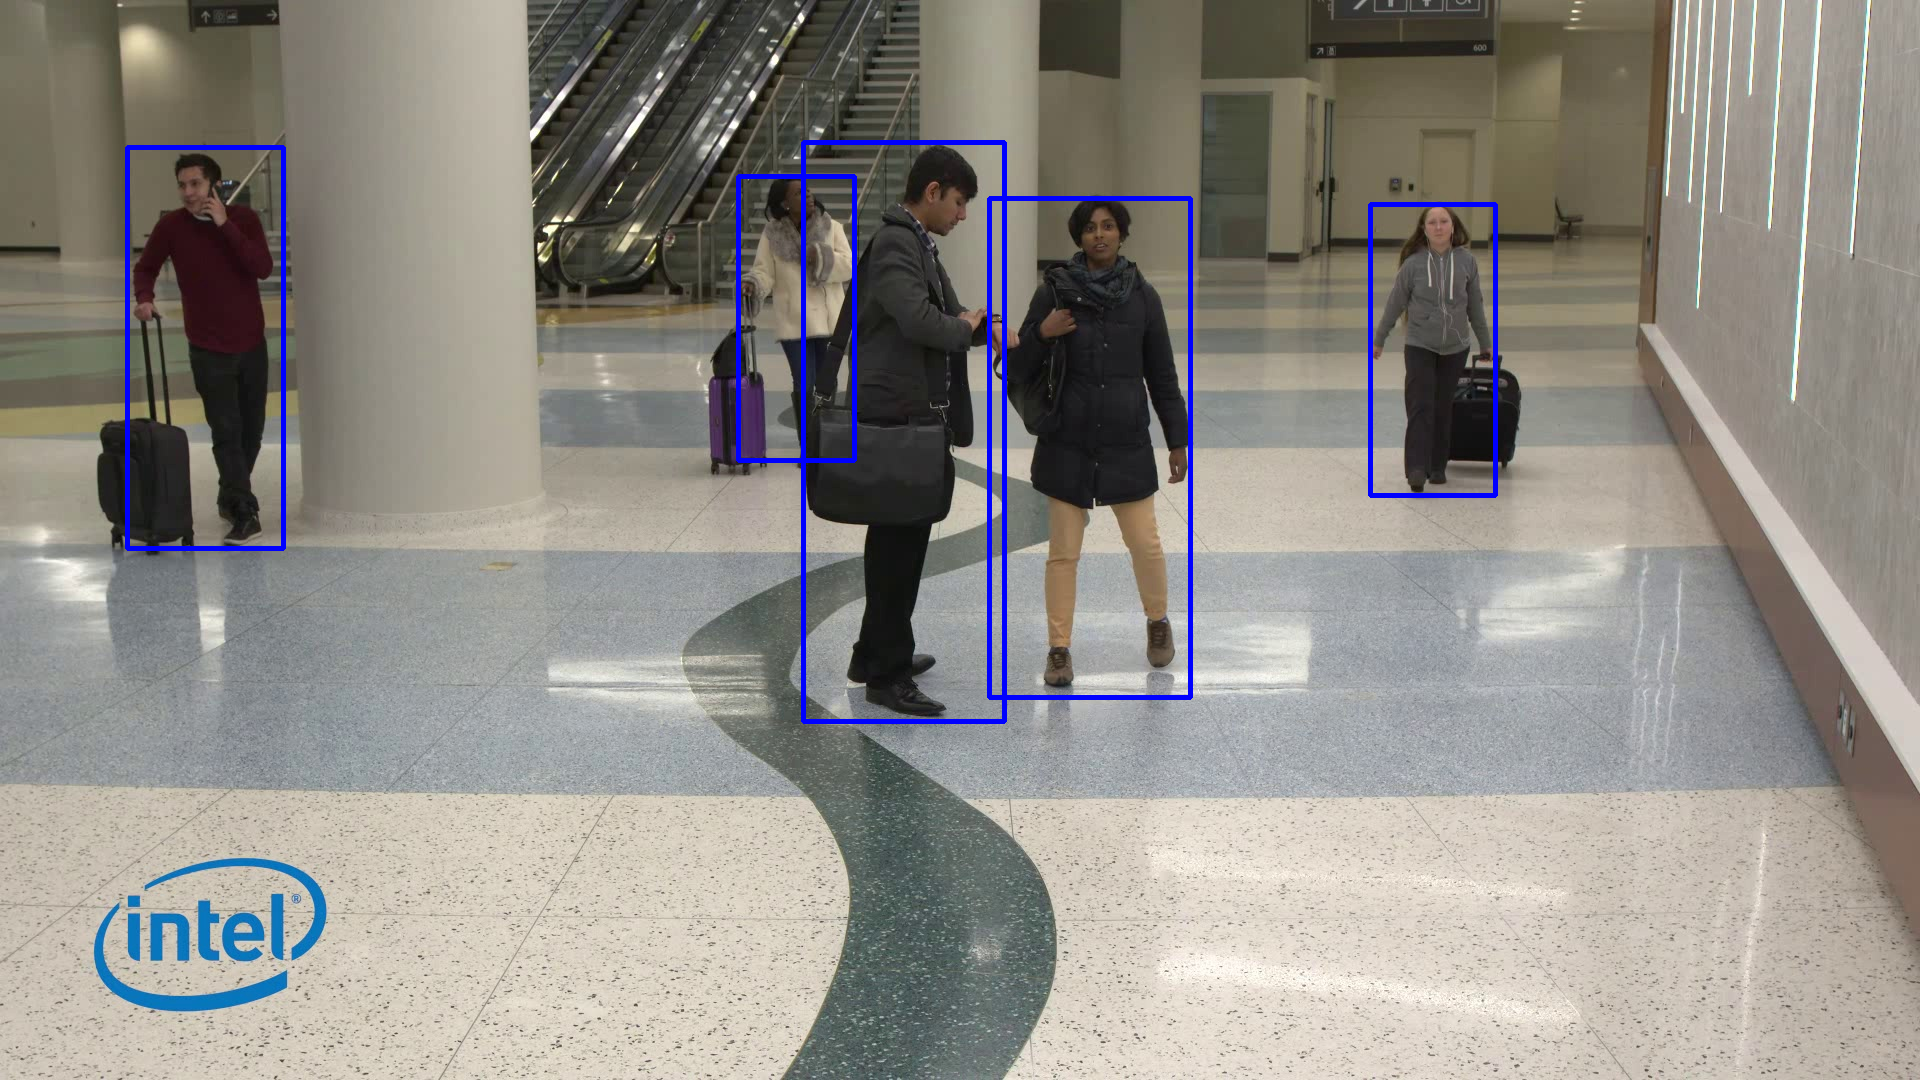

In [23]:
import IPython
import PIL

for predictions, item in zip(predicted_validation_dataset, validation_dataset.with_empty_annotations()):
    image = item.numpy.astype(np.uint8)
    for box in predictions.annotation_scene.shapes:
        x1 = int(box.x1 * image.shape[1])
        x2 = int(box.x2 * image.shape[1])
        y1 = int(box.y1 * image.shape[0])
        y2 = int(box.y2 * image.shape[0])
        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 0, 255), 3)  
    IPython.display.display(PIL.Image.fromarray(image))
    break